In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

metadata = pd.read_csv("HAM10000_metadata.csv")

In [2]:
metadata_cleaned = metadata.dropna(subset=['age'])


In [3]:
categorical_cols = ['sex', 'localization']
metadata = pd.get_dummies(metadata_cleaned, columns=categorical_cols)


In [4]:
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])


In [5]:
image_folder = './HAM10000_images'
IMAGE_SIZE = (128, 128)

def load_image(image_id):
    image_path = os.path.join(image_folder, image_id + '.jpg')
    try:
        image = Image.open(image_path).resize(IMAGE_SIZE)
        image = np.array(image) / 255.0 
        return image
    except:
        return None

In [7]:
metadata['image'] = metadata['image_id'].apply(load_image)
metadata = metadata[metadata['image'].notnull()]

X_images = np.stack(metadata['image'].values)

In [8]:
X_metadata = metadata.drop(['lesion_id', 'image_id', 'dx', 'dx_type', 'image', 'label'], axis=1)
numerical_cols = ['age']
scaler = StandardScaler()
X_metadata[numerical_cols] = scaler.fit_transform(X_metadata[numerical_cols])
X_metadata = X_metadata.values

y = metadata['label'].values


In [9]:
smote = SMOTE(random_state=42)
X_metadata_resampled, y_resampled = smote.fit_resample(X_metadata, y)

n_original_samples = len(y)
n_resampled_samples = len(y_resampled)
n_synthetic_samples = n_resampled_samples - n_original_samples

synthetic_metadata = X_metadata_resampled[n_original_samples:]
synthetic_labels = y_resampled[n_original_samples:]


In [10]:
synthetic_images = []
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [11]:
for idx in range(len(synthetic_metadata)):
    class_label = synthetic_labels[idx]
    class_indices = np.where(y == class_label)[0]
    selected_index = np.random.choice(class_indices)
    selected_image = X_images[selected_index]
    image = np.expand_dims(selected_image, axis=0)
    augmented_iterator = datagen.flow(image, batch_size=1)
    augmented_image = next(augmented_iterator)[0]
    synthetic_images.append(augmented_image)

synthetic_images = np.array(synthetic_images)


In [13]:
synthetic_images = np.array(synthetic_images, dtype=np.float32) 

In [14]:
X_images = X_images.astype(np.float32) 
X_images_resampled = np.concatenate((X_images, synthetic_images), axis=0)

In [15]:
synthetic_metadata = synthetic_metadata.astype(np.float32)  
X_metadata_resampled = np.concatenate((X_metadata.astype(np.float32), synthetic_metadata), axis=0)


In [16]:
y_resampled = np.concatenate((y, synthetic_labels), axis=0)


In [17]:
num_classes = len(np.unique(y_resampled))
y_resampled_one_hot = tf.keras.utils.to_categorical(y_resampled, num_classes=num_classes)


In [18]:

X_images_train, X_images_test, X_metadata_train, X_metadata_test, y_train, y_test = train_test_split(
    X_images_resampled, X_metadata_resampled, y_resampled_one_hot, test_size=0.2, random_state=42
)

In [19]:
X_images_train = np.array(X_images_train, dtype=np.float32)
X_metadata_train = np.array(X_metadata_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_images_test = np.array(X_images_test, dtype=np.float32)
X_metadata_test = np.array(X_metadata_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [20]:
# create model
image_input = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)


In [21]:
metadata_input = Input(shape=(X_metadata_train.shape[1],))
m = layers.Dense(64, activation='relu')(metadata_input)
m = layers.Dropout(0.5)(m)
m = layers.Dense(32, activation='relu')(m)

In [22]:
combined = layers.concatenate([x, m])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(num_classes, activation='softmax')(z)

In [23]:
model = Model(inputs=[image_input, metadata_input], outputs=z)

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,280 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7)         │        455 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 123,879 (483.90 KB)

 Trainable params: 123,879 (483.90 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    [X_images_train, X_metadata_train],
    y_train,
    validation_data=([X_images_test, X_metadata_test], y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20


c:\Users\tillb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_9']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1166/1166 ━━━━━━━━━━━━━━━━━━━━ 83s 69ms/step - accuracy: 0.3587 - loss: 1.5926 - val_accuracy: 0.6103 - val_loss: 1.0376
Epoch 2/20
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - accuracy: 0.6023 - loss: 1.0500 - val_accuracy: 0.6374 - val_loss: 0.9522
Epoch 3/20
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 76s 66ms/step - accuracy: 0.6275 - loss: 0.9752 - val_accuracy: 0.6611 - val_loss: 0.8842
Epoch 4/20
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 76s 65ms/step - accuracy: 0.6443 - loss: 0.9399 - val_accuracy: 0.6347 - val_loss: 0.9450
Epoch 5/20
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 75s 64ms/step - accuracy: 0.6551 - loss: 0.8922 - val_accuracy: 0.6557 - val_loss: 0.9105
Epoch 6/20
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 75s 64ms/step - accuracy: 0.6718 - loss: 0.8548 - val_accuracy: 0.6977 - val_loss: 0.7916
Epoch 7/20
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.6774 - loss: 0.8367 - val_accuracy: 0.7026 - val_loss: 0.7761
Epoch 8/20
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - accuracy: 0.6936 - loss: 0.80

In [26]:
loss, accuracy = model.evaluate([X_images_test, X_metadata_test], y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7792 - loss: 0.5947
Test Loss: 0.5915
Test Accuracy: 0.7800


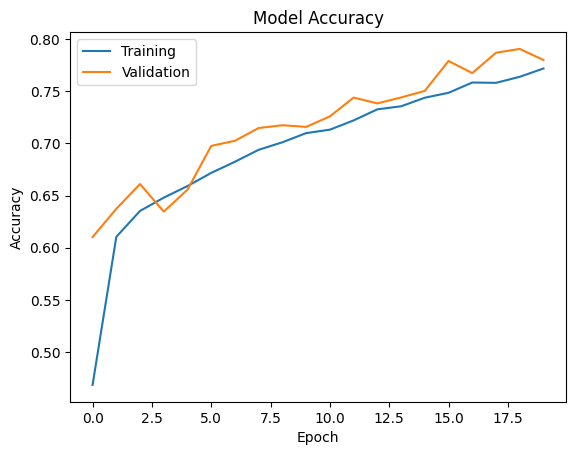

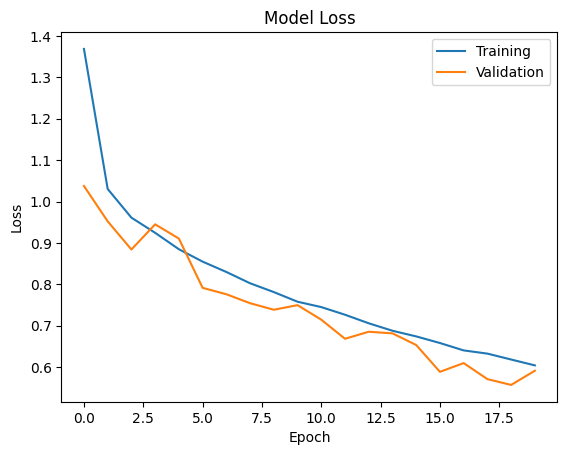

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [28]:
model.save("basicCNN_oversampled_smote_augmentation.h5")